In [1]:
# please make sure your drive_path is set, so that the notebook can find the data files on the hard drive

# OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/cell_types_cache/'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/cell_types_cache/'

# AWS
drive_path = '/data/dynamic-brain-workshop/cell_types_cache/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from allensdk.core.cell_types_cache import CellTypesCache

In [3]:
ctc = CellTypesCache()

In [4]:
# pd.DataFrame(ctc.get_cells()).head()
cells = pd.DataFrame(ctc.get_cells(reporter_status='positive'))
print len(cells)
# cells.head()
# print cells.groupby(by='transgenic_line').size()
region = 'VISp'

inh_lines = []
exc_lines = []
exc_st = ['Rorb','Scnn','Nr5','Rbp','Emx','Cux','Tlx3','Sim1','Ntsr']
inh_st = ['Gad','Htr','Pvalb','Vip','Sst']
for line in cells.transgenic_line.unique():
    for st in exc_st:
        if line.startswith(st):
            exc_lines.append(line)
    for st in inh_st:
        if line.startswith(st):
            inh_lines.append(line)


has_line = False
# lines = ['Rorb-IRES2-Cre']
for line in inh_lines:
    has_line = has_line | (cells.transgenic_line==line)
inh_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name=='5')]
print len(inh_cells)

for line in exc_lines:
    has_line = has_line | (cells.transgenic_line==line)
exc_cells = cells[(cells.species=='Mus musculus')& has_line & (cells.structure_area_abbrev==region) & (cells.structure_layer_name=='5')]
print len(exc_cells)


1813
196
361


In [5]:
#for cell in cell_types_class ...
epd = ctc.get_ephys_data(cells['id'][0])

2018-08-26 00:36:39,124 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/659446233


In [6]:
names = []
for i in epd.get_experiment_sweep_numbers():
    names.append(epd.get_sweep_metadata(i)['aibs_stimulus_name'])
print np.unique(names)

[u'Long Square' u'Noise 1' u'Noise 2' u'Ramp' u'Short Square'
 u'Square - 0.5ms Subthreshold' u'Square - 2s Suprathreshold' u'Test']


In [7]:
def get_sweeps_with_stim(ephys_data,stim_type):
    sweeps = []
    for i in ephys_data.get_experiment_sweep_numbers():
        if str.startswith(str(ephys_data.get_sweep_metadata(i)['aibs_stimulus_name']),stim_type):
            sweep = ephys_data.get_sweep(i)
            sweep['spike_times'] = ephys_data.get_spike_times(i)
            sweeps.append(sweep)
    return sweeps

def bin_spikes_and_stim(sweeps,bin_len,zpad=0):
    spikes_list = []
    stim_list = []
    for sweep in sweeps:
        T = int(np.floor(sweep['index_range'][1]*1.0/(sweep['sampling_rate']*bin_len)))
        binned_spikes = np.zeros((T,))
        binned_stim = np.empty((T,))
        for spike_time in sweep['spike_times']:
            t = int(np.floor(spike_time/bin_len))
            binned_spikes[t]+=1
        for i in range(T):
            binned_stim[i] = np.mean(sweep['stimulus'][int(np.round(i*bin_len*sweep['sampling_rate'])):int(np.round((i+1)*bin_len*sweep['sampling_rate']))])
        spikes_list.append(binned_spikes)
        stim_list.append(binned_stim)
        if zpad>0:
            spikes_list.append(np.zeros((int(np.floor(zpad/bin_len)),)))
            stim_list.append(np.zeros((int(np.floor(zpad/bin_len)),)))
    binned_spikes = np.concatenate(spikes_list)
    binned_stim = np.concatenate(stim_list)
    return (binned_spikes, binned_stim)
        

In [33]:
sweeps = get_sweeps_with_stim(epd,'Noise')
bin_len = 0.002
(binned_spikes, binned_stim) = bin_spikes_and_stim([sweeps[0]],bin_len)

(37500, 1400999)
50000.0
['stimulus', 'index_range', 'spike_times', 'stimulus_unit', 'sampling_rate', 'response']


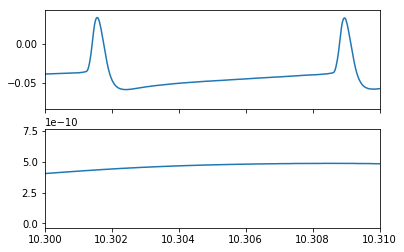

In [34]:

i=5
t = np.arange(0,sweeps[i]['index_range'][1]+1)*1.0/sweeps[i]['sampling_rate']
fig,ax = plt.subplots(2,1,sharex=True)
ax[1].plot(t,sweeps[i]['stimulus'])
ax[0].plot(t,sweeps[i]['response'])
plt.xlim(10.3,10.31)
print sweeps[5]['index_range']
print sweeps[5]['sampling_rate']
print sweeps[5].keys()


(10.3, 10.35)

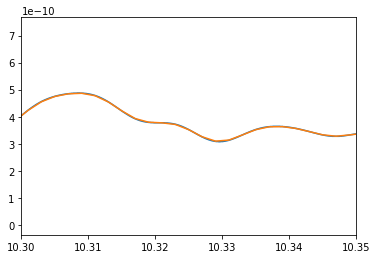

In [36]:
plt.plot(t,sweeps[0]['stimulus'])
plt.plot((np.arange(0,binned_stim.shape[0])+0.5)*bin_len,binned_stim)
plt.xlim([10.3,10.35])

(10.3, 10.5)

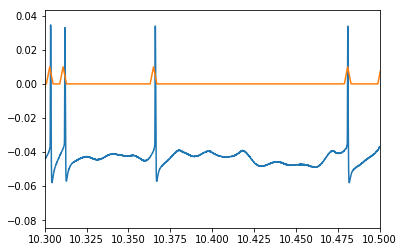

In [39]:
plt.plot(t,sweeps[0]['response'])
plt.plot((np.arange(0,binned_stim.shape[0])+0.5)*bin_len,binned_spikes*0.01)
plt.xlim([10.3,10.5])

In [ ]:
(K,W) = GLM_network_fit(binned_stim,binned_spikes,100, 100)

In [ ]:
plt.plot(np.squeeze(K))

In [ ]:
plt.plot(np.squeeze(W))

In [ ]:
Ks = []
Ws = []
fig,ax = plt.subplots(2,1,sharex=True)

for sweeps in [get_sweeps_with_stim(ctc.get_ephys_data(c_id),'Noise') for c_id in inh_cells['id']][:2]:
    (binned_spikes, binned_stim) = bin_spikes_and_stim(sweeps,bin_len)
    (K,W) = GLM_network_fit(binned_stim,binned_spikes,100, 100)
    Ks.append(K)
    Ws.append(W)
    ax[0].plot(np.squeeze(K))
    ax[1].plot(np.squeeze(W))